In [14]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import easyocr
import matplotlib.pyplot as plt
import cv2
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [15]:
import os

# Define the directory path
directory = 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images'

# List all the files in the directory
files = os.listdir(directory)


# Filter files based on your desired pattern
filtered_files = [file for file in files if file.endswith('.xml')]
path=[]
# Print the filtered files
print("\nFiltered files:")
for file in filtered_files:
    f= os.path.join(directory, file)
    path.append(f)
 



Filtered files:


In [16]:
# path = glob('D:\automatic-number-plate-recognition-python-yolov8\images\*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [17]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,D:\automatic-number-plate-recognition-python-y...,226,419,125,173
1,D:\automatic-number-plate-recognition-python-y...,134,262,128,160
2,D:\automatic-number-plate-recognition-python-y...,140,303,5,148
3,D:\automatic-number-plate-recognition-python-y...,175,214,114,131
4,D:\automatic-number-plate-recognition-python-y...,167,240,202,220


In [18]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images',filename_image)
    return filepath_image
getFilename(filename)

'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars0.png'

In [19]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars0.png',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars1.png',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars10.png',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars100.png',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars101.png',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars102.png',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars103.png',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars104.png',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars105.png',
 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\images\\Cars106.png']

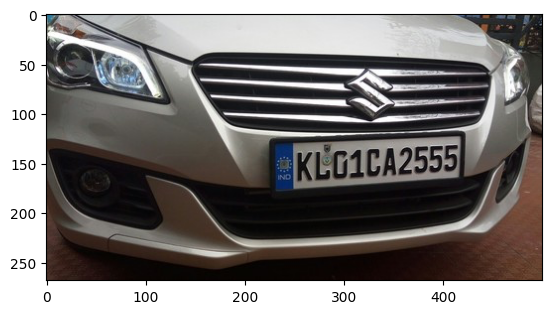

In [20]:
file_path = image_path[0] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
plt.imshow(img)


In [21]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [22]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

plt.imshow(X[4])

In [23]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((346, 224, 224, 3), (87, 224, 224, 3), (346, 4), (87, 4))

In [24]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [25]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_203 (Conv2D)         (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_203 (B  (None, 111, 111, 32)         96        ['conv2d_203[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_203 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_20

                                                                                                  
 activation_205 (Activation  (None, 109, 109, 64)         0         ['batch_normalization_205[0][0
 )                                                                  ]']                           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)           0         ['activation_205[0][0]']      
 g2D)                                                                                             
                                                                                                  
 conv2d_206 (Conv2D)         (None, 54, 54, 80)           5120      ['max_pooling2d_4[0][0]']     
                                                                                                  
 batch_normalization_206 (B  (None, 54, 54, 80)           240       ['conv2d_206[0][0]']          
 atchNorma

In [26]:
model.load_weights('./object_detection1.h5')

In [27]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=5,epochs=10,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/10
70/70 [==============================] - 178s 2s/step - loss: 9.3004e-04 - val_loss: 0.0301
Epoch 2/10
70/70 [==============================] - 157s 2s/step - loss: 9.8034e-04 - val_loss: 0.0230
Epoch 3/10
70/70 [==============================] - 151s 2s/step - loss: 8.2983e-04 - val_loss: 0.0239
Epoch 4/10
70/70 [==============================] - 154s 2s/step - loss: 7.5142e-04 - val_loss: 0.0140
Epoch 5/10
70/70 [==============================] - 145s 2s/step - loss: 6.7269e-04 - val_loss: 0.0168
Epoch 6/10
70/70 [==============================] - 142s 2s/step - loss: 9.1480e-04 - val_loss: 0.0135
Epoch 7/10
70/70 [==============================] - 144s 2s/step - loss: 0.0011 - val_loss: 0.0195
Epoch 8/10
70/70 [==============================] - 145s 2s/step - loss: 8.9382e-04 - val_loss: 0.0118
Epoch 9/10
70/70 [==============================] - 144s 2s/step - loss: 6.4472e-04 - val_loss: 0.0133
Epoch 10/10
70/70 [==============================] - 148s 2s/step - loss: 9.2

In [28]:
model.save('./object_detection1.h5')

c:\Users\pulki\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
model = tf.keras.models.load_model('./object_detection1.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [93]:
path = "D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\TEST\\TEST.jpeg"
image = load_img(path)
image = np.array(image,dtype=np.uint8) 
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0 


h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)


Height of the image = 570
Width of the image = 870


In [94]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [95]:
coords = model.predict(test_arr)
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords = coords.astype(np.int32)


1/1 [==============================] - 0s 267ms/step


In [96]:
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(199, 292) (635, 389)


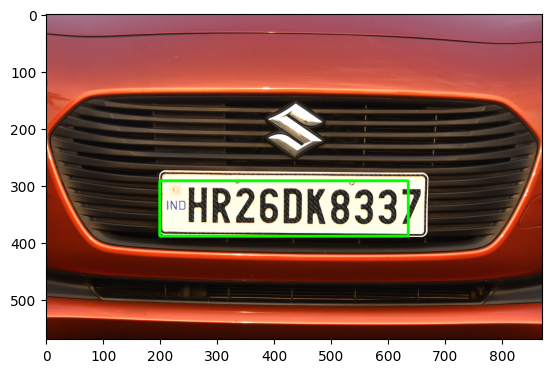

In [97]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
plt.imshow(image)

In [98]:
path = 'D:\\automatic-number-plate-recognition-python-yolov8\\anpr\\TEST\\TEST.jpeg'
def object_detection(path):
    
    image = load_img(path) 
    image = np.array(image,dtype=np.uint8) 
    image1 = load_img(path,target_size=(224,224))
    
    image_arr_224 = img_to_array(image1)/255.0 
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    coords = model.predict(test_arr)
    
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)



1/1 [==============================] - 0s 264ms/step
(199, 292) (635, 389)


In [99]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


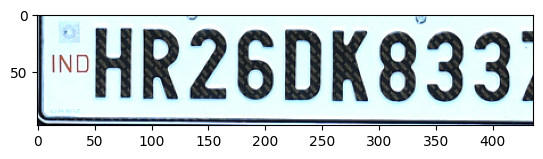

In [100]:


image = roi

reader = easyocr.Reader(['en'])  

result = reader.readtext(image)
out=[]
for detection in result:
    out.append(detection[1])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [101]:
print(' '.join(out))

IND HRZGDK8337
